## 回归话题补充
两种不同的训练模型的方式
- 通过闭式方程，直接计算出最拟合训练集的模型参数
- 迭代优化的方式：梯度下降和它的变体：批量梯度下降，小批量梯度下降以及随机梯度下降

多种正则化技巧
- 岭回归，Lasso回归和弹性网络回归

分类任务模型
- 针对多分类的softmax回归

### 闭式方程
$$
\hat{\theta} = (X^\top X)^{-1} X^\top y
$$

这个方程中：

- $\hat{\theta}$ 是使代价函数最小的 $\theta$ 值。
- $y$ 是包含 $y^{(1)}$ 到 $y^{(m)}$ 的目标值向量。


In [2]:
# 生成假数据
import numpy as np
from matplotlib.lines import lineStyles
from pyexpat.model import XML_CQUANT_PLUS

np.random.seed(100)

m = 100
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)

In [3]:
# 用方程拟合
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # X里 增加一列1
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best

array([[3.98485975],
       [2.86232606]])

In [4]:
# 做出预测
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new) # X_new里 增加一列1
y_predict = X_new_b @ theta_best
y_predict

array([[3.98485975],
       [9.70951187]])

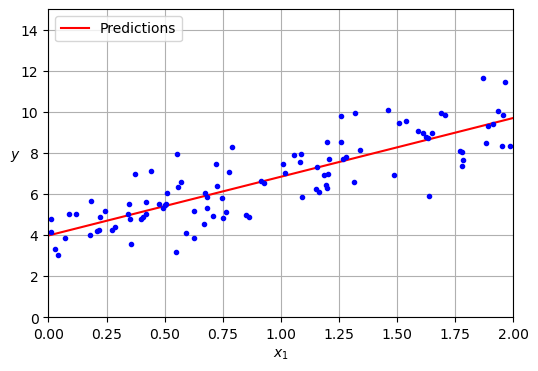

In [5]:
# 绘制预测结果
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

# extra code – beautifies and saves Figure 4–2
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

In [6]:
# 使用sklearn做更简单了
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_
lin_reg.predict(X_new)

array([[3.98485975],
       [9.70951187]])

In [7]:
# LinearRegression类基于 np.linalg.lstsq()函数，可以直接调用它
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.98485975],
       [2.86232606]])

In [8]:
# 上面的函数计算的是 X的伪逆(np.linalg.pinv(), Moore-Penrose逆） 和 y的矩阵乘法
np.linalg.pinv(X_b) @ y

array([[3.98485975],
       [2.86232606]])

伪逆本身是使用被称为奇异值分解(Singular Value Decomposition，SVD)的标准矩阵分解技术来计算的，可以分解训练集矩阵X为三个矩阵UΣV⊤的乘积［numpy.linalg.svd()］。伪逆的计算公式为：X+=VΣ+U⊤。为了计算矩阵Σ+，该算法取Σ并将所有小于一个小阈值的值设置为零，然后将所有非零值替换成它们的倒数，最后把结果矩阵转置。这种方法比计算标准方程更有效，而且它可以很好地处理边缘情况：的确，标准方程可能没有解，如果矩阵X⊤X是不可逆的（即奇异的），例如如果m＜n或某些特征是多余的，但伪逆总是有定义的。

#### 计算复杂度
标准方程计算$X^⊤X$的逆，是一个(n+1)×(n+1)的矩阵（n是特征数量）。对这种矩阵求逆的计算复杂度通常为O(n^2.4)到O(n^3)之间，取决于具体实现。换句话说，如果将特征数量翻倍，那么计算时间将乘以大约2^2.4=5.3倍到2^3=8倍。Scikit-Learn的LinearRegression类使用的SVD方法复杂度约为O(n^2)。如果你将特征数量加倍，那计算时间大约是原来的4倍。

特征数量比较大（例如100000）时，标准方程和SVD的计算将极其缓慢。好的一面是，相对于训练集中的实例数量[O(m)]来说，两个都是线性的，所以能够有效地处理大量的训练集，只要内存足够。同样，线性回归模型一经训练（不论是标准方程还是其他算法）​，预测就非常快速：因为计算复杂度相对于想要预测的实例数量和特征数量来说，都是线性的。换句话说，对两倍的实例（或者是两倍的特征）进行预测，大概需要两倍的时间。

### 梯度下降
- 更适合特征数量或者训练实例数量大到内存无法满足要求的场景。

- 要点复习：不同尺度的特征梯度下降速度不一样，应用梯度下降时，需要保证所有特征值的大小比例都差不多（Sklearn的StandardScaler类），否则收敛的时间会长很多
![有和没有特征缩放的梯度下降](./images/regression/p1.png)

左边的训练集特征1和特征2有相同的数值规模，而右边的训练集上，特征1的值比特征2要小得多。（因为特征1较小，需要比特征2有更大的变化才能影响代价函数，这也是被拉长的特征是更小的特征的原因）

In [9]:
# 批量梯度下降算法快速实现
eta = 0.1 # 学习率
n_epochs = 1000
m = len(X_b)

np.random.seed(100)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    gradients = X_b.T @ (X_b @ theta - y) / m
    theta = theta - eta * gradients


In [10]:
theta

array([[3.9848596],
       [2.8623262]])

#### 随机梯度下降(Stochastic Gradient Descent)


批量梯度下降的主要问题是它要用整个训练集来计算每一步的梯度，所以当训练集很大时，算法会特别慢。与之相反的极端是随机梯度下降，随机梯度下降每一步在训练集中随机选择一个实例，并且仅基于该单个实例来计算梯度。显然，这让算法变得快多了，因为每个迭代都只需要操作少量的数据。它也可以被用来训练海量的数据集，因为每次迭代只需要在内存中运行一个实例（SGD可以作为核外算法实现，大量数据无法一次载入内存，分批训练）。另外，由于算法的随机性质，它比批量梯度下降要不规则得多。代价函数将不再是缓缓降低直到抵达最小值，而是不断上上下下，但是从整体来看，还是在慢慢下降。随着时间推移，代价函数最终会非常接近最小值，但是即使它到达了最小值，依旧会持续反弹，永远不会停止。一旦算法停止，最终的参数值会很好，但不是最优的。

![随机梯度下降的路线图](./images/regression/p2.png)

当代价函数非常不规则时，随机梯度下降其实可以帮助算法跳出局部最小值，所以相比批量梯度下降，它对找到全局最小值更有优势。因此，随机性的好处在于可以逃离局部最优，但缺点是永远定位不出最小值。

要解决这个困境，有一个办法是逐步降低学习率。开始的步长比较大（这有助于快速进展和逃离局部最小值），然后越来越小，让算法尽量靠近全局最小值。这个过程叫作模拟退火，因为它类似于冶金时熔化的金属慢慢冷却的退火过程。确定每个迭代学习率的函数叫作学习率调度。如果学习率降得太快，可能会陷入局部最小值，甚至停留在走向最小值的半途中。如果学习率降得太慢，你需要很长时间才能跳到最小值附近，如果提早结束训练，可能只得到一个次优的解决方案。

学习率调度理解：eta = 1.0 / (alpha * (t + t0))； t0和alpha两个超参数需要提前确定； 或者是 按 eta = eta0 / (1+k*t)理解, eta0是初始学习率，k是衰减的速度

In [11]:
# 有学习率调度的随机梯度下降实现

n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(100)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for iteration in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = xi.T @ (xi @ theta - yi)  # 单个样本的梯度 不需要除以m
        eta = learning_schedule(epoch*m + iteration)
        theta = theta - eta * gradients


In [12]:
theta

array([[3.98380275],
       [2.87435455]])

用随机梯度下降时，训练实例必须独立且在同一个概率分布下(Independent and Identically Distributed，IID)，以确保平均而言将参数拉向全局最优值。确保这一点的一种简单方法是在训练过程中对实例进行随机混洗（例如，随机选择每个实例，或者在每个轮次开始时随机混洗训练集）。如果不对实例进行混洗（例如，如果实例按标签排序）​，那么SGD将首先针对一个标签进行优化，然后针对下一个标签进行优化，以此类推，并且它不会接近全局最小值。

要使用带有Scikit-Learn的随机梯度下降执行线性回归，可以使用SGDRegressor类，该类默认优化MSE代价函数。以下代码最多可运行1000个轮次(max_iter)，或者直到 连续100个轮次训练后，损失下降小于10-5(tol)为止(n_iter_no_change)。它使用默认的学习调度（与前一个使用的不同）以0.01(eta0)的学习率开始（eta0/迭代次数)。最后，它不使用任何正则化（penalty=None）

In [13]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, n_iter_no_change=100, random_state=100)
# sgd_reg.fit(X, y) # DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([3.98345809]), array([2.86442731]))

#### 小批量梯度下降（Mini-Batch gradient descent)

最后一个梯度下降算法变体称为小批量梯度下降。了解了批量和随机梯度下降后，就很容易理解它：在每一步中，不是根据完整的训练集（如批量GD）或仅基于一个实例（如随机GD）来计算梯度，小批量GD在称为小型批量的随机实例集上计算梯度。小批量GD优于随机GD的主要优点是，可以通过矩阵操作的硬件优化来提高性能，特别是在使用GPU时。

与随机GD相比，该算法在参数空间上的进展更稳定，尤其是在相当大的小批次中。小批量GD最终将比随机GD走得更接近最小值，但它可能很难摆脱局部最小值（在受局部最小值影响的情况下，不像有MSE代价函数的线性回归）。下图展示了训练期间参数空间中三种梯度下降算法所采用的路径。它们最终都接近最小值，但是批量GD的路径实际上是在最小值处停止，而随机GD和小批量GD都继续走动。但是，要记住批量GD每步需要花费很多时间，如果使用了良好的学习率调度，则随机GD和小批量GD也会达到最小值。

![不同梯度下降在参数空间中的路径](./images/regression/p3.png)

- 线性回归算法的比较

![线性回归的算法比较](./images/regression/p4.png)

### 多项式回归

In [31]:
np.random.seed(100)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

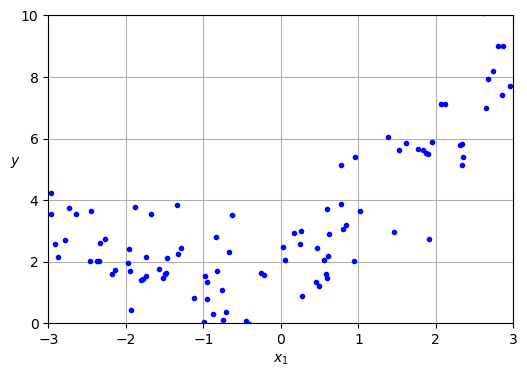

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

In [33]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly_features.fit_transform(X)
X_poly.shape
X[0]
X_poly[0] # X_poly包含X的原始特征以及该特征的平方

array([0.26042965, 0.0678236 ])

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.84320636]), array([[0.95406518, 0.50130709]]))

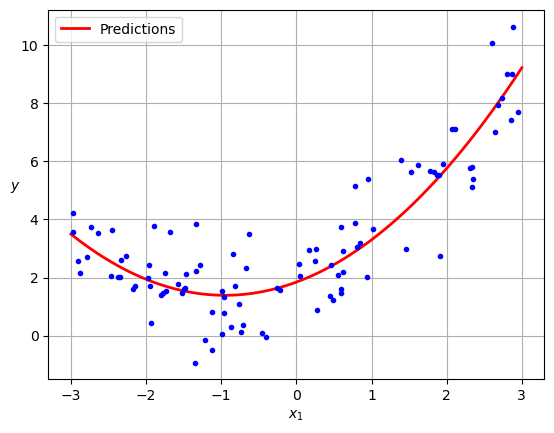

In [35]:
# 随堂练习，利用lin_reg的预测能力 和 poly_features的组合特征的能力，生成抛物线

plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.show()

-注意：PolynomialFeatures可以将特征的所有组合添加到给定的多项式阶数。例如特征a和b，degree=3,会有ab，a^2 * b, ab^2. PolynomialFeatures(degree=d)可以将一个包含n个特征的数组转换为包含(n+d)!/(d!n!)个特征的数组, 要小心特征组合的数量爆炸


### 学习曲线
所有sklearn估计器都可以使用fit()方法进行训练，有一些估计器还有partial_fit()方法，可以调用该方法在一个或多个实例上运行单轮训练。

反复调用partial_fit()会逐渐训练模型。可能同时有一个warm_start=True的超参数，如果warm_start=True,则在训练模型调用fit()方法将不会重置模型，它会在停止的地方继续训练。

sklearn的学习曲线可以得到模型的训练误差和验证误差随训练集大小变化的图（类似于反复调用partial_fit(), 每次评估一次训练和验证误差），如果不支持partial_fit()或warm_start, 则必须在训练集逐渐变大的子集上多次训练它。

sklearn的learning_curve函数返回它评估模型的训练集大小，以及它为每个大小和每个交叉验证测量的训练和验证分数

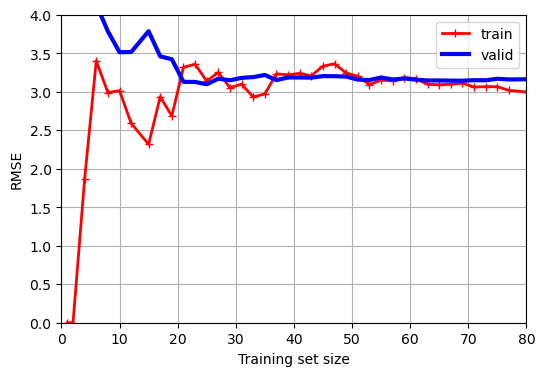

In [52]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5, scoring="neg_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, c="r", linewidth=2, label="train", linestyle="-", marker="+")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 4])
plt.show()

这是个典型的欠拟合learning curve：训练集只有1-2个实例时，模型完全贴合，红色曲线从0开始，但是随着将新实例添加到训练集中，模型不能完美拟合数据，训练误差一致上升，直到达到平稳状态

验证误差：很多训练集时，无法正确泛化，一开始验证误差很大，随着样例变多，验证误差逐渐降低，但误差没降低多少已经趋于平稳，接近训练的误差曲线。

-> 典型的欠拟合状态：两条曲线趋于平稳，很接近，很高。

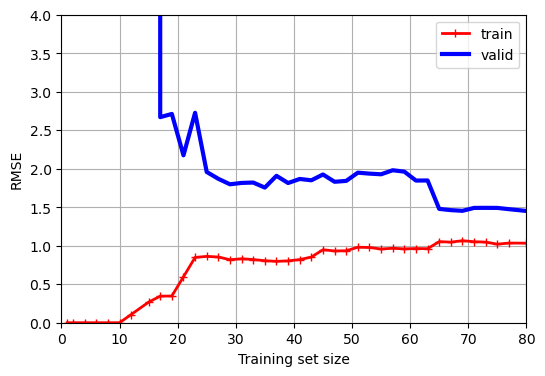

In [68]:
# 随堂练习：生成相同数据上10阶多项式模型的学习曲线（如下图） 提示：可以把Polynomial feature和LinearRegression组成一个流水线


这个学习曲线和之前的区别：
- 和之前比，训练数据上的误差要低得多
- 曲线之间存在间隙。这意味着该模型在训练数据上的性能要比在验证数据上的性能好得多，这是过拟合的标志。但是，如果使用更大的训练集，则两条曲线会继续接近

**理论：偏差/方差权衡**

- 偏差/方差权衡统计学和机器学习的重要理论成果是以下一个事实：模型的泛化误差可以表示为三个非常不同的误差之和：
- 偏差：这部分泛化误差的原因在于错误的假设，比如假设数据是线性的，而实际上是二次的。高偏差模型最有可能对训练数据欠拟合。
- 方差：这部分是由于模型对训练数据的细微变化过于敏感。具有许多自由度的模型（例如高阶多项式模型）可能具有较高的方差，因此可能过拟合训练数据。
- 不可避免的误差：这部分误差是因为数据本身的噪声所致。减少这部分误差的唯一方法就是清洗数据（例如修复数据源（如损坏的传感器），或者检测并移除异常值）。

增加模型的复杂度通常会显著提升模型的方差，减少偏差。反过来，降低模型的复杂度则会提升模型的偏差，降低方差。这就是为什么称其为权衡。

### 正则化线性模型
讨论的是通过约束模型的权重实现的正则化，岭回归（Ridge，L2正则化）， 套索回归（Lasso，L1正则化），弹性网络回归（Elastic Net，L1+L2正则化）

#### 岭回归

岭回归（L2正则化）是线性回归的正则化版本：将等于$\frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2$的正则化项添加到MSE。这迫使学习算法不仅拟合数据，而且还使模型权重尽可能地小。请注意，仅在训练期间将正则化项添加到代价函数中。训练模型后，你希望使用非正则化MSE（或RMSE）来评估模型的性能。

超参数α控制要对模型进行正则化的程度。如果α=0，则岭回归仅是线性回归。如果α非常大，则所有权重最终都非常接近于零，结果是一条经过数据均值的平线。
$$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2
$$

请注意，偏置项 $\theta_0$ 没有进行正则化（总和从 $i=1$ 开始，而不是 0）。
如果我们将 $\mathbf{w}$ 定义为特征权重的向量（$\theta_1$ 至 $\theta_n$），则正则项等于 $\alpha \|\mathbf{w}\|_2^2$，其中 $\|\mathbf{w}\|_2$ 表示权重向量的 $\ell_2$ 范数。

对于梯度下降，只需将 $\frac{2\alpha}{m} \mathbf{w}$ 添加到 MSE 梯度向量中对应于特征权重的部分，而不添加任何偏差项的梯度。

在执行岭回归之前缩放数据（例如使用StandardScaler）很重要，因为它对输入特征的缩放敏感。大多数正则化模型都需要如此。

In [69]:
# alpha的增加会导致更平坦的预测，从而减少了模型的方差，但增加了其偏差
np.random.seed(100)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

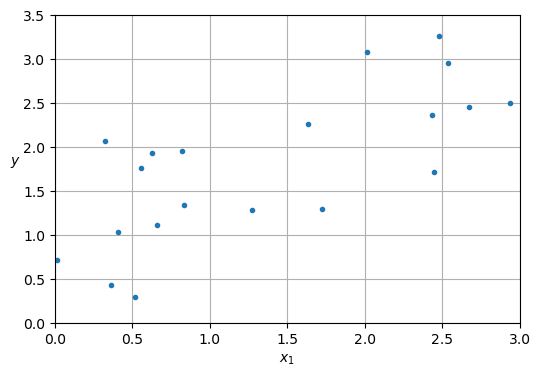

In [70]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

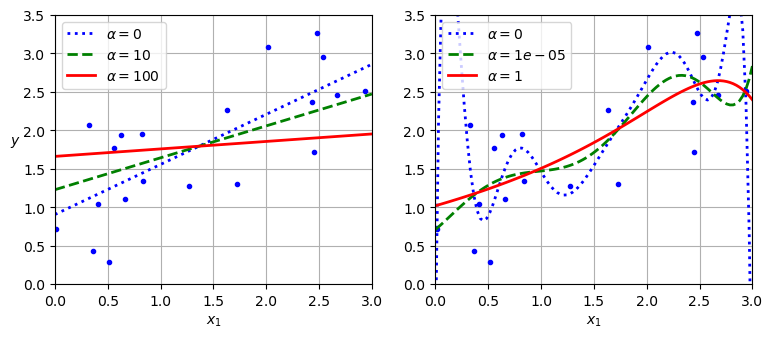

In [75]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(1,2,1)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=100)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(1,2,2)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=100)
plt.show()

alpha增加会导致更平坦的预测，从而减少了模型的方差，但增加了其偏差。

岭回归可以通过计算闭合形式的方程 或执行梯度下降执行， 闭式解公式：$
\hat{\boldsymbol{\theta}} = (X^\top X + \alpha A)^{-1} X^\top \mathbf{y}
$


In [79]:
# 岭回归可以通过计算闭合形式的方程 或执行梯度下降执行
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.1, solver="cholesky")  # 闭式解公式的变体
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

# penalty="l2", alpha=0.1/m -> 添加正则项 alpha * l2范数的平方，这里 0.1/m，/m要手动添加，获得和Ridge(alpha=0.1)一样的效果
#  tol=None表示不会提前停止，跑到max_iter规定的次数
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1/m, tol=None, max_iter=1000, eta0=0.1, random_state=100)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.88777645])

RidgeCV类也执行岭回归，但它使用交叉验证自动调整超参数。它大致相当于使用GridSearchCV，但它针对岭回归进行了优化并且运行速度更快。其他几个估计器（主要是线性的）也有高效的CV变体，例如LassoCV和ElasticNetCV。

#### Lasso回归
